In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50 #50x50 images, either screw with aspect ratio or pad or shift + crop or rotate or flip (ver/hor)
    CATS = "Datasets/PetImages/Cat"
    DOGS = "Datasets/PetImages/Dog"

    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            #tqdm is progress bar
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [21]:
training_data = np.load("training_data.npy", allow_pickle = True)
print(len(training_data))

Exception ignored in: <function tqdm.__del__ at 0x7f7ef4cbc5e0>
Traceback (most recent call last):
  File "/Users/test/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/test/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


24946


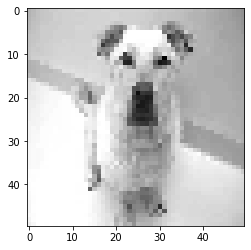

In [22]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()
        

In [24]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

x = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
x = x/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 #divide data set into traning and test
val_size = int(len(x)*VAL_PCT)
print(val_size)
train_x = x[:-val_size]
train_y = y[:-val_size]

test_x = x[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(test_x))

2494
22452
2494


In [25]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad() #optimizer.zero_grad()
        outputs = net(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)



100%|██████████| 225/225 [00:36<00:00,  6.22it/s]

tensor(0.2029, grad_fn=<MseLossBackward0>)


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:02<00:00, 1188.19it/s]

Accuracy:  0.623
